# Simple FEM for one dimensional Burgers' equation

The problem for $u(t,x)$ is stated as
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0 \quad \text{for} \quad x \in [-1,1] , t \in [0, 0.5]
$$
with $\nu=\frac{0.01}{\pi}$ subject to the boundary condition
$$
u(t, x=0) = 0
$$
and the initial condition
$$
u(t=0, x) = -\sin(\pi x)
$$

## Spacial and time domains

We represent the inner points in space and time by a set of collocation points.

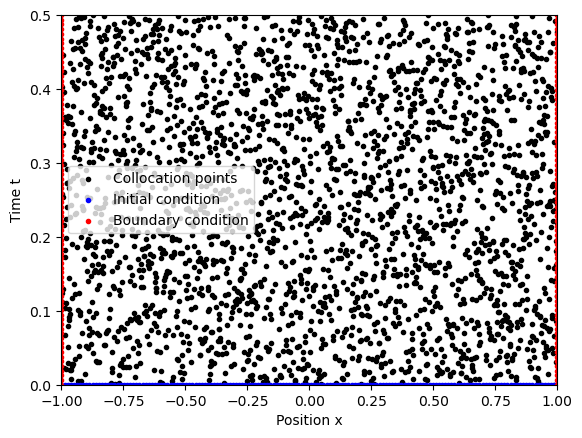

In [25]:
import torch 
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create collocation points on domain and enable gradients on these tensors
N = 80
points = qmc.LatinHypercube(d=2).random(2540)
x_collocation = torch.tensor(2 * points[:,0], requires_grad=True).float() - 1.0
t_collocation = torch.tensor(0.5 * points[:,1], requires_grad=True).float()

# Initial points and prescribed initial values
x = torch.linspace(-1, 1, 2*N)
t0 = torch.zeros_like(x)
ut0 = -torch.sin(np.pi*x)

# Boundary points and prescribed boundary values
t = torch.linspace(0, 0.5, N)
x_left = -torch.ones_like(t)
x_right = torch.ones_like(t)
ux0 = torch.zeros_like(t)

# Build dataset for training
input_x = torch.cat([x, x_right, x_left])
input_t = torch.cat([t0, t, t])
output_T = torch.cat([ut0, ux0, ux0])[:, None]

# Visualize locations of all training points
plt.scatter(x_collocation.detach(), t_collocation.detach(), c="k", marker=".")
plt.scatter(x, t0, c="b", marker=".")
plt.scatter(x_left, t, c="r", marker=".")
plt.scatter(x_right, t, c="r", marker=".")
plt.xlabel("Position x")
plt.xlim([-1,1])
plt.ylabel("Time t")
plt.ylim([0, 0.5])
plt.legend(["Collocation points", "Initial condition", "Boundary condition"])

## The ANN model that approximates the function T

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $T: \mathcal{R}^2 \rightarrow \mathcal{R}$ with five hidden layers having 10 neurons each.

In [26]:
# build a dense multi-layer perceptron ANN to approximate the temperature
# Input are x and t, output is T
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(2,20)
        self.hidden_layer2 = torch.nn.Linear(20,20)
        self.hidden_layer3 = torch.nn.Linear(20,20)
        self.output_layer = torch.nn.Linear(20,1)

    def forward(self, x,t):
        inputs = torch.column_stack([x, t])
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out)
        return output

net = Net()

## Evaluate physics-informed loss

The pysics-informed part of the PINN is achieved by including the residual of an PDE as loss function. To compute that loss, we use automatic differentiation to obtain gradients of $T$. The loss function is then
$$
    \mathcal{L} = \mathcal{L}_\text{BC} + W \mathcal{L}_\text{PDE}
$$
with 
$$
    \mathcal{L}_\text{BC} = \frac{1}{N} \sum_{i=1}^{N} || \hat{u}_i(x_0, t_0) - u_i ||^2
$$
at the boundary points and intial points and 
$$
    \mathcal{L}_\text{PDE} = \frac{1}{M} \sum_{i=1}^{M} || \frac{\partial \hat{u}}{\partial t} + \hat{u} \frac{\partial \hat{u}}{\partial x} - \nu \frac{\partial^2 \hat{u}}{\partial x^2} ||^2
$$
in the timespace domain. Ehe hyperparameter $W$ determines the weight of the PDE residual in comparison to the data residual.

In [27]:
# Hyperparameter to weight the PDE loss
W = 1.0

# PDE parameter
nu = 0.01/torch.pi

mse = torch.nn.MSELoss()

def pde_residual(x, t):
    u = net(x, t).ravel()
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    return u_t + u*u_x - nu*u_xx 

def compute_loss():
    # Loss from boundary conditions
    pred_bc = net(input_x, input_t)
    mse_bc = mse(pred_bc, output_T)
    
    # Loss based on PDE
    pred_pde = pde_residual(x_collocation, t_collocation)
    mse_pde = mse(pred_pde, torch.zeros_like(x_collocation))
    
    # Combining the loss functions
    return mse_bc + W * mse_pde


## Train the PINN 
We adjust the weights such that the loss is minimized over several epochs.

In [28]:
history = []

print("Starting with Adam optimizer...")
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
for epoch in tqdm(range(15000)):
    optimizer.zero_grad()
    loss = compute_loss()
    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
    	history.append(float(loss.data))

print("Switching to LBFGS optimizer for fine tuning...")
optimizer = torch.optim.LBFGS(net.parameters())
for epoch in tqdm(range(5000)):
    def closure():
        optimizer.zero_grad()
        loss = compute_loss()
        loss.backward()
        with torch.autograd.no_grad():
            history.append(float(loss.data))
        return loss
    optimizer.step(closure)


Starting with Adam optimizer...


100%|██████████| 15000/15000 [01:14<00:00, 201.52it/s]


Switching to LBFGS optimizer for fine tuning...


100%|██████████| 5000/5000 [00:56<00:00, 88.05it/s] 


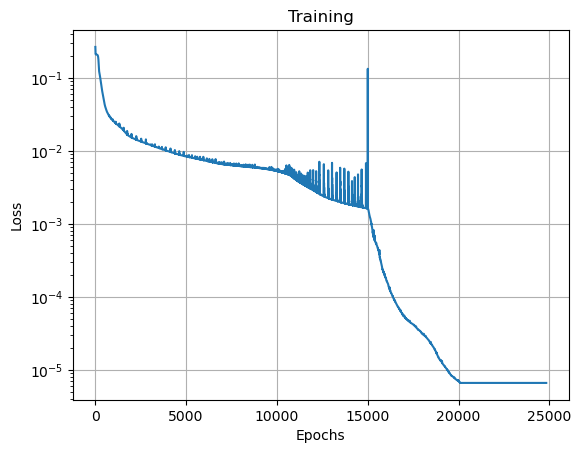

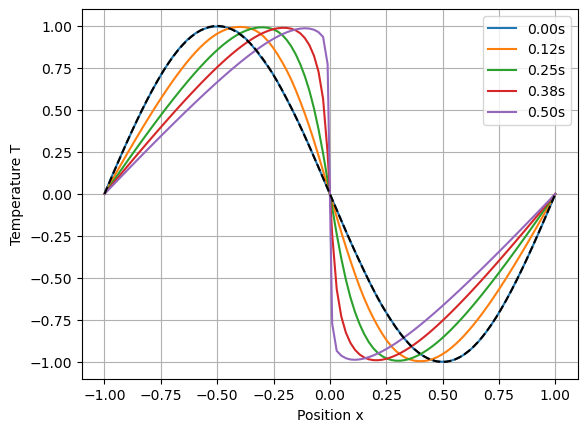

In [29]:
# Plot history of optimization
plt.semilogy(history)
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid("both")
plt.show()

# Plot results
for i in range(5):
    val_x = torch.linspace(-1, 1, 100, requires_grad=True)
    val_t = 0.1 * i * torch.ones_like(val_x, requires_grad=True)
    u_v = net(val_x, val_t)
    plt.plot(val_x.detach(), u_v.detach())
plt.plot(val_x.detach(), -np.sin(np.pi*val_x.detach()), "--k")
plt.legend([f"{t:.2f}s" for t in np.linspace(0, 0.5, 5) ])
plt.xlabel("Position x")
plt.ylabel("Temperature T")
plt.grid()
plt.show()